In [1]:
import numpy as np
import torch
import pandas as pd
import glob
import numpy as np
import pandas as pd
import yaml
import math
import scipy.io as sio
from pathlib import Path

from plotting import *
from utils import *
from TMP_model import MP_model,TestTMPModel

In [ ]:
# Extract motion of videos for each subject and save all subfiles
#  in a folder same name of videos in the same directory of original video 

In [13]:
import scipy.io as sio
import os

# List of all subjects to process
all_subjects = [1,2,3,4,10,11,12,13,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,
            31,34,35,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51]

completed_subjects = [1,2,10,11,12,13,15,16,17,18,19,22, 20,21,23,24,25,26,27,28,29,30,31,32,33,34,35,36]
subjects = []

v3d_base_path = '../../../data/01_raw/F_Subjects/'
video_base_path = '../../../data/'

for subject_id in subjects:
    v3d_file = f'{v3d_base_path}F_v3d_Subject_{subject_id}.mat'
    video_file = f'{video_base_path}F_PG1_Subject_{subject_id}_L.avi'
    
    # Process the subject
    try:
        main_rub = sio.loadmat(v3d_file, squeeze_me=True, struct_as_record=False)
        single_videos(video_file, main_rub)
        print(f"Successfully processed Subject {subject_id}")
    except Exception as e:
        print(f"Error processing Subject {subject_id}: {e}")

Created output directory: ../../../data/F_PG1_Subject_27_L
Loaded existing motion mapping with 32 entries.
Available motions in this file:
Saved motion mapping with 32 entries.
Video processing complete. All segments saved to ../../../data/F_PG1_Subject_27_L
Successfully processed Subject 27
Created output directory: ../../../data/F_PG1_Subject_28_L
Available motions in this file:
Saved motion mapping with 32 entries.
Video processing complete. All segments saved to ../../../data/F_PG1_Subject_28_L
Successfully processed Subject 28
Created output directory: ../../../data/F_PG1_Subject_29_L
Available motions in this file:
Saved motion mapping with 32 entries.
Video processing complete. All segments saved to ../../../data/F_PG1_Subject_29_L
Successfully processed Subject 29
Created output directory: ../../../data/F_PG1_Subject_30_L
Available motions in this file:
Saved motion mapping with 32 entries.
Video processing complete. All segments saved to ../../../data/F_PG1_Subject_30_L
Succes

In [ ]:
# In this step, I gave those extracted motion videos to MMpose on the #####server
# got 3d pose json files on server. 
# Now I load separated motion vidoes json file, 
# merge them in fixed order based on motion_mapping
# and concatenate them in one datafrma for each subject

In [ ]:


# # Get all JSON files in the source folder
# json_files = glob.glob(os.path.join(source_folder, "*.json"))

# for json_file_path in json_files:
#     print(f"Processing file: {json_file_path}")
    
#     # Load the JSON file
#     with open(json_file_path, 'r') as f:
#         predictions = json.load(f)
    
#     # Create empty lists to store the data
#     frame_ids = []
#     joint_names = []
#     x_3d = []
#     y_3d = []
#     z_3d = []
#     confidence = []
    
#     # Process each frame
#     for frame_data in predictions:
#         frame_id = frame_data["frame_id"]
        
#         # Check if there are instances in this frame
#         if 'instances' in frame_data and len(frame_data["instances"]) > 0:
#             # Get the first person (or you can loop through all if needed)
#             person_data = frame_data["instances"][0]
            
#             # Extract 3D keypoints - they are already in the 'keypoints' field
#             keypoints_3d = person_data['keypoints']
#             scores = person_data['keypoint_scores']
            
#             # Process each keypoint
#             for idx, (point, score) in enumerate(zip(keypoints_3d, scores)):
#                 if idx < len(H36M_KEYPOINT_NAMES):
#                     joint_name = H36M_KEYPOINT_NAMES[idx]
                    
#                     frame_ids.append(frame_id)
#                     joint_names.append(joint_name)
#                     x_3d.append(point[0])
#                     y_3d.append(point[1])
#                     z_3d.append(point[2])
#                     confidence.append(score)
    
#     # Create a DataFrame with the 3D keypoint data
#     df_3d = pd.DataFrame({
#         'frame_id': frame_ids,
#         'joint_name': joint_names,
#         'x_3d': x_3d,
#         'y_3d': y_3d,
#         'z_3d': z_3d,
#         'confidence': confidence
#     })
    
#     # Get the filename without extension to use for saving
#     filename = os.path.basename(json_file_path)
#     filename_without_ext = os.path.splitext(filename)[0]
    
#     # Save the DataFrame to the destination folder with the same name (as CSV)
#     output_path = os.path.join(destination_folder, f"{filename_without_ext}.csv")
#     df_3d.to_csv(output_path, index=False)
    
#     print(f"Saved processed data to: {output_path}")
#     print(f"Sample data from {filename}:")
#     print(df_3d.head(3))
#     print("-" * 80)

In [10]:
import os
import glob
import json
import pandas as pd
import re

# Define constants
H36M_KEYPOINT_NAMES = [
    'Hip', 'RHip', 'RKnee', 'RAnkle', 'LHip', 'LKnee', 'LAnkle',
    'Spine', 'Thorax', 'Neck', 'Head',
    'LShoulder', 'LElbow', 'LWrist', 'RShoulder', 'RElbow', 'RWrist'
]

def create_csv_from_json(source_folder, destination_folder, subjects, equivalent_motions, id_to_motion):
    """
    Function to create CSV files from JSON motion files
    
    Args:
        source_folder: Directory containing subject folders with JSON files
        destination_folder: Directory to save individual CSV files
        subjects: List of subject IDs to process
        equivalent_motions: Dictionary mapping motion IDs to canonical IDs
        id_to_motion: Dictionary mapping motion IDs to motion names
    
    Returns:
        dict: Dictionary mapping subject IDs to their common motions
        list: List of motion IDs common to all subjects
    """
    os.makedirs(destination_folder, exist_ok=True)
    
    # Find subjects and their available motions
    subject_motions = {}

    for subject_id in subjects:
        subject_folder = os.path.join(source_folder, f"pred_Subject_{subject_id}")
        if os.path.exists(subject_folder):
            json_files = glob.glob(os.path.join(subject_folder, "*.json"))
            motion_ids = set()  # Using a set to automatically handle duplicates
            
            for json_file in json_files:
                filename = os.path.basename(json_file)
                # Extract motion ID from filename
                match = re.search(f"subject_{subject_id}_motion_(\\d+)", filename)
                if match:
                    motion_id = match.group(1)
                    # Convert to canonical ID if it's an equivalent motion
                    canonical_id = equivalent_motions.get(motion_id, motion_id)
                    motion_ids.add(canonical_id)
            
            subject_motions[subject_id] = list(motion_ids)

    # Find common motions across all subjects
    all_motion_sets = [set(motions) for motions in subject_motions.values()]
    if all_motion_sets:
        common_motions = set.intersection(*all_motion_sets)
        common_motions = sorted([int(m) for m in common_motions])
        print(f"Common motions across all subjects: {common_motions}")
        print(f"Motion names: {[id_to_motion.get(str(m), f'Unknown-{m}') for m in common_motions]}")
    else:
        common_motions = []
        print("No subjects with motions found.")

    # Process each subject
    for subject_id in subjects:
        subject_folder = os.path.join(source_folder, f"pred_Subject_{subject_id}")
        
        if not os.path.exists(subject_folder):
            print(f"Subject folder not found: {subject_folder}")
            continue
        
        # Process each motion for this subject
        for canonical_motion_id in common_motions:
            canonical_motion_id_str = str(canonical_motion_id)
            
            # Find all possible equivalent motion IDs for this canonical ID
            possible_motion_ids = [motion_id for motion_id, canon_id in equivalent_motions.items() 
                                    if canon_id == canonical_motion_id_str]
            # Also include the canonical ID itself
            if canonical_motion_id_str not in possible_motion_ids:
                possible_motion_ids.append(canonical_motion_id_str)
            
            # Try all possible motion IDs
            found = False
            for motion_id in possible_motion_ids:
                # Pad with leading zeros (both 2-digit and 1-digit formats for compatibility)
                padded_motion_id_2 = motion_id.zfill(2)
                padded_motion_id_1 = motion_id.zfill(1)
                
                # Try both padding formats
                for padded_id in [padded_motion_id_2, padded_motion_id_1]:
                    motion_pattern = f"subject_{subject_id}_motion_{padded_id}.json"
                    motion_files = glob.glob(os.path.join(subject_folder, motion_pattern))
                    
                    if motion_files:
                        json_file_path = motion_files[0]
                        filename = os.path.basename(json_file_path)
                        filename_without_ext = os.path.splitext(filename)[0]
                        
                        # Create CSV for this motion
                        output_path = os.path.join(destination_folder, f"{filename_without_ext}.csv")
                        
                        # Process the JSON file and create CSV
                        with open(json_file_path, 'r') as f:
                            predictions = json.load(f)
                        
                        # Create empty lists to store the data
                        frame_ids = []
                        joint_names = []
                        x_3d = []
                        y_3d = []
                        z_3d = []
                        confidence = []
                        
                        # Process each frame
                        for frame_data in predictions:
                            frame_id = frame_data["frame_id"]
                            
                            # Check if there are instances in this frame
                            if 'instances' in frame_data and len(frame_data["instances"]) > 0:
                                # Get the first person (or you can loop through all if needed)
                                person_data = frame_data["instances"][0]
                                
                                # Extract 3D keypoints
                                keypoints_3d = person_data['keypoints']
                                scores = person_data['keypoint_scores']
                                
                                # Process each keypoint
                                for idx, (point, score) in enumerate(zip(keypoints_3d, scores)):
                                    if idx < len(H36M_KEYPOINT_NAMES):
                                        joint_name = H36M_KEYPOINT_NAMES[idx]
                                        
                                        frame_ids.append(frame_id)
                                        joint_names.append(joint_name)
                                        x_3d.append(point[0])
                                        y_3d.append(point[1])
                                        z_3d.append(point[2])
                                        confidence.append(score)
                        
                        # Create a DataFrame with the 3D keypoint data
                        df_3d = pd.DataFrame({
                            'frame_id': frame_ids,
                            'joint_name': joint_names,
                            'x_3d': x_3d,
                            'y_3d': y_3d,
                            'z_3d': z_3d,
                            'confidence': confidence,
                            'motion_id': canonical_motion_id,
                            'original_motion_id': motion_id,
                            'motion_name': id_to_motion.get(canonical_motion_id_str, f'Unknown-{canonical_motion_id}'),
                            'subject_id': subject_id
                        })
                        
                        # Save the DataFrame to CSV
                        df_3d.to_csv(output_path, index=False)
                        
                        found = True
                        break
                
                if found:
                    break
    
    return subject_motions, common_motions

def merge_subject_csv_files(destination_folder, merged_folder, subjects, common_motions):
    """
    Function to merge CSV files for each subject
    
    Args:
        destination_folder: Directory containing individual CSV files
        merged_folder: Directory to save merged CSV files
        subjects: List of subject IDs to process
        common_motions: List of motion IDs common to all subjects
    """
    os.makedirs(merged_folder, exist_ok=True)
    
    for subject_id in subjects:
        # Dictionary to store dataframes for common motions
        subject_dfs = {}
        
        # Process each motion for this subject
        for canonical_motion_id in common_motions:
            # Try different padding formats for motion IDs in filenames
            found = False
            
            # Try with 2-digit padding (00, 01, etc.)
            padded_id = str(canonical_motion_id).zfill(2)
            csv_pattern = f"subject_{subject_id}_motion_{padded_id}.csv"
            csv_files = glob.glob(os.path.join(destination_folder, csv_pattern))
            
            if not csv_files:
                # Try with 1-digit padding (0, 1, etc.)
                padded_id = str(canonical_motion_id).zfill(1)
                csv_pattern = f"subject_{subject_id}_motion_{padded_id}.csv"
                csv_files = glob.glob(os.path.join(destination_folder, csv_pattern))
            
            if csv_files:
                # Load CSV file
                csv_file_path = csv_files[0]
                df = pd.read_csv(csv_file_path)
                subject_dfs[canonical_motion_id] = df
        
        # Merge all dataframes for this subject
        if subject_dfs:
            # Sort by motion_id to ensure consistent order
            sorted_dfs = [subject_dfs[motion_id] for motion_id in sorted(subject_dfs.keys()) if motion_id in subject_dfs]
            
            if sorted_dfs:  # Check if we have any dataframes to merge
                merged_df = pd.concat(sorted_dfs, ignore_index=True)
                
                # Save merged dataframe
                merged_output_path = os.path.join(merged_folder, f"subject_{subject_id}_all_motions.csv")
                merged_df.to_csv(merged_output_path, index=False)
                print(f"Created merged file for subject {subject_id} with {len(sorted_dfs)} motions")
            else:
                print(f"No common motions found for subject {subject_id}")


In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import os
import numpy as np
from matplotlib.gridspec import GridSpec

def visualize_joint_trajectories(merged_folder, output_folder, common_motions, subjects, id_to_motion):
    """
    Visualize joint trajectories for a specific motion across all subjects.
    
    Args:
        merged_folder: Directory containing merged CSV files
        output_folder: Directory to save visualization plots
        common_motions: List of common motion IDs
        subjects: List of subject IDs
        id_to_motion: Dictionary mapping motion IDs to motion names
    """
    os.makedirs(output_folder, exist_ok=True)
    
    # Iterate through each common motion
    for motion_id in common_motions:
        motion_name = id_to_motion.get(str(motion_id), f'Unknown-{motion_id}')
        print(f"Visualizing motion {motion_id}: {motion_name}")
        
        # Create a folder for this motion
        motion_folder = os.path.join(output_folder, f"motion_{motion_id}_{motion_name}")
        os.makedirs(motion_folder, exist_ok=True)
        
        # Dictionary to store data for each subject
        subject_data = {}
        
        # Load data for all subjects for this motion
        for subject_id in subjects:
            subject_file = os.path.join(merged_folder, f"subject_{subject_id}_all_motions.csv")
            if os.path.exists(subject_file):
                df = pd.read_csv(subject_file)
                # Extract only data for the current motion
                motion_df = df[df['motion_id'] == motion_id]
                if not motion_df.empty:
                    subject_data[subject_id] = motion_df
        
        if not subject_data:
            print(f"No data found for motion {motion_id}")
            continue
        
        # Get unique joints from the data
        sample_df = next(iter(subject_data.values()))
        all_joints = sample_df['joint_name'].unique()
        
        # Visualize trajectory for each joint
        for joint in all_joints:
            print(f"  Visualizing joint: {joint}")
            
            # Figure for 3D visualization
            # fig_3d = plt.figure(figsize=(12, 10))
            # ax_3d = fig_3d.add_subplot(111, projection='3d')
            # ax_3d.set_title(f'3D Trajectory of {joint} - Motion: {motion_name} (ID: {motion_id})')
            # ax_3d.set_xlabel('X')
            # ax_3d.set_ylabel('Y')
            # ax_3d.set_zlabel('Z')
            
            # 2D visualization of X, Y, Z coordinates over time
            fig_2d = plt.figure(figsize=(16, 10))
            gs = GridSpec(3, 1, figure=fig_2d)
            ax_x = fig_2d.add_subplot(gs[0, 0])
            ax_y = fig_2d.add_subplot(gs[1, 0])
            ax_z = fig_2d.add_subplot(gs[2, 0])
            
            ax_x.set_title(f'X Coordinate of {joint} Over Time - Motion: {motion_name} (ID: {motion_id})')
            ax_y.set_title(f'Y Coordinate of {joint} Over Time')
            ax_z.set_title(f'Z Coordinate of {joint} Over Time')
            
            ax_x.set_ylabel('X Position')
            ax_y.set_ylabel('Y Position')
            ax_z.set_ylabel('Z Position')
            ax_z.set_xlabel('Frame Number')
            
            # Color map for different subjects
            cmap = plt.cm.get_cmap('tab20', len(subject_data))
            
            # Plot data for each subject
            for i, (subject_id, df) in enumerate(subject_data.items()):
                # Get data for this joint
                joint_df = df[df['joint_name'] == joint].sort_values('frame_id')
                
                if joint_df.empty:
                    continue
                
                color = cmap(i)
                label = f'Subject {subject_id}'
                
                # Extract coordinates
                x = joint_df['x_3d'].values
                y = joint_df['y_3d'].values
                z = joint_df['z_3d'].values
                frames = joint_df['frame_id'].values
                
                # 3D trajectory plot
                # ax_3d.plot(x, y, z, marker='o', markersize=2, linestyle='-', linewidth=1, color=color, label=label)
                
                # 2D plots over time
                ax_x.plot(frames, x, marker='o', markersize=2, linestyle='-', linewidth=1, color=color, label=label)
                ax_y.plot(frames, y, marker='o', markersize=2, linestyle='-', linewidth=1, color=color)
                ax_z.plot(frames, z, marker='o', markersize=2, linestyle='-', linewidth=1, color=color)
            
            # Add legends
            # ax_3d.legend()
            ax_x.legend()
            
            # Adjust layout
            # fig_3d.tight_layout()
            fig_2d.tight_layout()
            
            # Save plots
            # fig_3d.savefig(os.path.join(motion_folder, f"{joint}_3D_trajectory.png"), dpi=300)
            fig_2d.savefig(os.path.join(motion_folder, f"{joint}_coordinates_over_time.png"), dpi=300)
            
            # Close figures to save memory
            # plt.close(fig_3d)
            plt.close(fig_2d)
            
        # Create a combined visualization for all joints in this motion
        visualize_motion_overview(subject_data, motion_id, motion_name, motion_folder, all_joints)

def visualize_motion_overview(subject_data, motion_id, motion_name, output_folder, all_joints):
    """
    Create an overview visualization showing all joints for a single subject
    
    Args:
        subject_data: Dictionary of dataframes by subject ID
        motion_id: Motion ID being visualized
        motion_name: Name of the motion
        output_folder: Folder to save the visualization
        all_joints: List of all joint names
    """
    # Choose a sample subject for overview visualization
    sample_subject_id = next(iter(subject_data.keys()))
    sample_df = subject_data[sample_subject_id]
    
    # Create figures for overview
    fig = plt.figure(figsize=(18, 12))
    gs = GridSpec(3, 1, height_ratios=[1, 1, 1], figure=fig)
    
    # 3 subplots for X, Y, Z coordinates
    ax_x = fig.add_subplot(gs[0, 0])
    ax_y = fig.add_subplot(gs[1, 0])
    ax_z = fig.add_subplot(gs[2, 0])
    
    ax_x.set_title(f'X Coordinates of All Joints - Motion: {motion_name} (ID: {motion_id}) - Subject {sample_subject_id}')
    ax_y.set_title('Y Coordinates of All Joints')
    ax_z.set_title('Z Coordinates of All Joints')
    
    ax_x.set_ylabel('X Position')
    ax_y.set_ylabel('Y Position')
    ax_z.set_ylabel('Z Position')
    ax_z.set_xlabel('Frame Number')
    
    # Color map for different joints
    cmap = plt.cm.get_cmap('tab20', len(all_joints))
    
    # Plot each joint
    for i, joint in enumerate(all_joints):
        # Get data for this joint
        joint_df = sample_df[sample_df['joint_name'] == joint].sort_values('frame_id')
        
        if joint_df.empty:
            continue
        
        color = cmap(i)
        
        # Extract coordinates
        x = joint_df['x_3d'].values
        y = joint_df['y_3d'].values
        z = joint_df['z_3d'].values
        frames = joint_df['frame_id'].values
        
        # Plot coordinates over time
        ax_x.plot(frames, x, marker='', linestyle='-', linewidth=1, color=color, label=joint)
        ax_y.plot(frames, y, marker='', linestyle='-', linewidth=1, color=color)
        ax_z.plot(frames, z, marker='', linestyle='-', linewidth=1, color=color)
    
    # Add legend
    ax_x.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
    
    # Adjust layout
    fig.tight_layout()
    
    # Save plot
    fig.savefig(os.path.join(output_folder, f"all_joints_overview_subject_{sample_subject_id}.png"), dpi=300)
    plt.close(fig)



In [11]:

# Define settings and parameters
subjects = [20, 21, 1, 2, 10, 11, 12, 13, 15, 16, 17, 18, 19, 22, 23, 24, 25, 26]
source_folder = '../../../data/MMpose/pred_out'
destination_folder = "../../../data/MMpose/df_files_3d"
merged_folder = "../../../data/MMpose/merged_csv_files"
visualization_folder = "../../../data/MMpose/visualizations"

# Load motion mapping
with open('../../../data/motion_mapping.json', 'r') as f:
    motion_mapping = json.load(f)['mapping']
    # Invert mapping for easier lookup
    id_to_motion = {str(v): k for k, v in motion_mapping.items()}

# Define equivalent motions - map to canonical ID
equivalent_motions = {
    # Format: ID: canonical_ID
    "20": "20",  # stretching -> stretching
    "31": "20",  # stretching_rm -> stretching
    "11": "11",  # cross_arms -> cross_arms
    "24": "11",  # crossarms -> cross_arms
    "12": "12",  # jumping_jacks -> jumping_jacks
    "23": "12",  # jumping_jack -> jumping_jacks
}

 
subject_motions, common_motions = create_csv_from_json(
    source_folder, destination_folder, subjects, equivalent_motions, id_to_motion
)
    
merge_subject_csv_files(destination_folder, merged_folder, subjects, common_motions)


Common motions across all subjects: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20]
Motion names: ['hand_clapping', 'jogging', 'walking', 'cross_legged_sitting', 'vertical_jumping', 'crawling', 'hand_waving', 'running_in_spot', 'checking_watch', 'kicking', 'taking_photo', 'cross_arms', 'jumping_jacks', 'scratching_head', 'throw/catch', 'pointing', 'sitting_down', 'sideways', 'phone_talking', 'stretching']


In [14]:
motions_to_visualize = [2, 12]
visualize_joint_trajectories(merged_folder, visualization_folder, motions_to_visualize, subjects, id_to_motion)


Visualizing motion 2: walking
  Visualizing joint: Hip


/tmp/ipykernel_21282/281771536.py:80: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(subject_data))


  Visualizing joint: RHip
  Visualizing joint: RKnee
  Visualizing joint: RAnkle
  Visualizing joint: LHip
  Visualizing joint: LKnee
  Visualizing joint: LAnkle
  Visualizing joint: Spine
  Visualizing joint: Thorax
  Visualizing joint: Neck
  Visualizing joint: Head
  Visualizing joint: LShoulder
  Visualizing joint: LElbow
  Visualizing joint: LWrist
  Visualizing joint: RShoulder
  Visualizing joint: RElbow
  Visualizing joint: RWrist


/tmp/ipykernel_21282/281771536.py:160: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(all_joints))


Visualizing motion 12: jumping_jacks
  Visualizing joint: Hip


/tmp/ipykernel_21282/281771536.py:80: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(subject_data))


  Visualizing joint: RHip
  Visualizing joint: RKnee
  Visualizing joint: RAnkle
  Visualizing joint: LHip
  Visualizing joint: LKnee
  Visualizing joint: LAnkle
  Visualizing joint: Spine
  Visualizing joint: Thorax
  Visualizing joint: Neck
  Visualizing joint: Head
  Visualizing joint: LShoulder
  Visualizing joint: LElbow
  Visualizing joint: LWrist
  Visualizing joint: RShoulder
  Visualizing joint: RElbow
  Visualizing joint: RWrist


/tmp/ipykernel_21282/281771536.py:160: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(all_joints))


In [ ]:
# Now we have 3d pose data csv files in same order motion videos for all subjects
# Visualize some frames in one sample csv file to verify 3d data

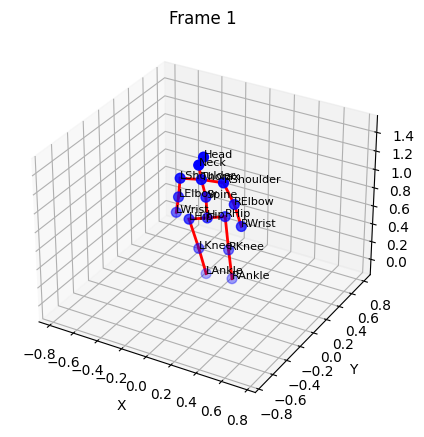

In [21]:
csv_file_path = "../../../data/MMpose/merged_csv_files/subject_10_all_motions.csv"  

if not os.path.exists(csv_file_path):
    print(f"Error: File not found at {csv_file_path}")
else:
    df_3d = pd.read_csv(csv_file_path)

first_frame_id = 1
fig = visualize_frame_3d(df_3d, first_frame_id)

# If you want to verify multiple frames, you could do:
# for frame_id in df_3d['frame_id'].unique()[2:7]:  # First 5 frames
#     visualize_frame_3d(df_3d, frame_id)

In [22]:
# Now we need to convert csv files to bvh format so we can use for TMP model

In [4]:
source_folder =  "../../../data/MMpose/merged_csv_files"
destination_folder = "../../../data/MMpose/bvh_files"  

os.makedirs(destination_folder, exist_ok=True)

csv_files = glob.glob(os.path.join(source_folder, "*.csv"))

for file_path in csv_files:
    print(f"Processing file: {file_path}")
    
    with open(file_path, 'r') as f:
        df_3d = pd.read_csv(f)

    filename = os.path.basename(file_path)
    filename_without_ext = os.path.splitext(filename)[0]
    output_bvh_path = os.path.join(destination_folder, f"{filename_without_ext}.bvh")
    create_h36m_bvh(df_3d, output_bvh_path, fps=120)

Processing file: ../../../data/MMpose/merged_csv_files/subject_17_all_motions.csv
BVH file created at ../../../data/MMpose/bvh_files/subject_17_all_motions.bvh
Processing file: ../../../data/MMpose/merged_csv_files/subject_23_all_motions.csv
BVH file created at ../../../data/MMpose/bvh_files/subject_23_all_motions.bvh
Processing file: ../../../data/MMpose/merged_csv_files/subject_22_all_motions.csv
BVH file created at ../../../data/MMpose/bvh_files/subject_22_all_motions.bvh
Processing file: ../../../data/MMpose/merged_csv_files/subject_26_all_motions.csv
BVH file created at ../../../data/MMpose/bvh_files/subject_26_all_motions.bvh
Processing file: ../../../data/MMpose/merged_csv_files/subject_11_all_motions.csv
BVH file created at ../../../data/MMpose/bvh_files/subject_11_all_motions.bvh
Processing file: ../../../data/MMpose/merged_csv_files/subject_18_all_motions.csv
BVH file created at ../../../data/MMpose/bvh_files/subject_18_all_motions.bvh
Processing file: ../../../data/MMpose/me

In [5]:


def convert_motion_id_to_bvh(motion_id, id_to_motion=None):
    source_folder = "../../../data/MMpose/df_files_3d"
    
    # Create a specific destination folder for this motion
    motion_name = id_to_motion.get(str(motion_id), f"motion_{motion_id}") if id_to_motion else f"motion_{motion_id}"
   
    destination_folder = f"../../../data/MMpose/bvh_files/bvh_files_motion_{motion_id}_{motion_name}"
    

    os.makedirs(destination_folder, exist_ok=True)
    
    # Format motion ID with zero-padding to match filename format
    padded_motion_id = str(motion_id).zfill(2)
    
    # Get all CSV files for the specific motion
    csv_pattern = f"subject_*_motion_{padded_motion_id}.csv"
    csv_files = glob.glob(os.path.join(source_folder, csv_pattern))
    
    print(f"Processing motion ID: {motion_id} ({motion_name})")
    print(f"Found {len(csv_files)} CSV files for this motion")
    
    for file_path in csv_files:
        
        df_3d = pd.read_csv(file_path)
        
        filename = os.path.basename(file_path)
        filename_without_ext = os.path.splitext(filename)[0]
        output_bvh_path = os.path.join(destination_folder, f"{filename_without_ext}.bvh")
        
        create_h36m_bvh(df_3d, output_bvh_path, fps=120)
        
        print(f"Created BVH file: {output_bvh_path}")
    
    print(f"Conversion complete for motion {motion_id} ({motion_name})")


In [2]:
# get motion capture data for specific motion 
with open('../../../data/motion_mapping.json', 'r') as f:
    motion_mapping = json.load(f)['mapping']
    # Invert mapping for easier lookup
    id_to_motion = {str(v): k for k, v in motion_mapping.items()}


# Convert a specific motion ID to BVH
motion_id = 4  # Example: 2: walking
motion_name = id_to_motion.get(str(motion_id), f"unknown_motion_{motion_id}")
print(motion_name)
convert_motion_id_to_bvh(motion_id, id_to_motion=id_to_motion)
destination_folder = f"../../../data/MMpose/bvh_files/bvh_files_motion_{motion_id}_{motion_name}"
    

vertical_jumping


NameError: name 'convert_motion_id_to_bvh' is not defined

Model Training

In [3]:


folder_path = "../../../data/MMpose/bvh_files" 
# folder_path = destination_folder  # if specific motion is assumed for trainng only
    # Read BVH files
bvh_data = read_bvh_files(folder_path)
if not bvh_data:
    raise ValueError("No BVH files could be read")

# Process data according to paper specifications
processed_data2 = process_bvh_data(bvh_data)
# a = [torch.tensor(d) for d in processed_data2]
num_segments = len(processed_data2)


# based on TMP code: the format of data=list(segment_data[signals,time]) --> signals are fixed but time 
# could vary in segments
# as far as i underastand:
# num segments = number of videos we have (each subject)
# num_signals =  number of sensors/signals. = number of features / joint infor in data = 54 here
print(f'num of segments : {num_segments}')
num_signals = processed_data2[0].shape[0]
print(f'num of signal : {num_signals}')


Processed segment shape: (54, 368)
Processed segment shape: (54, 301)
Processed segment shape: (54, 290)
Processed segment shape: (54, 236)
Processed segment shape: (54, 408)
Processed segment shape: (54, 228)
Processed segment shape: (54, 378)
Processed segment shape: (54, 334)
Processed segment shape: (54, 501)
Processed segment shape: (54, 284)
Processed segment shape: (54, 373)
Processed segment shape: (54, 530)
Processed segment shape: (54, 367)
Processed segment shape: (54, 412)
Processed segment shape: (54, 330)
Processed segment shape: (54, 278)
Processed segment shape: (54, 293)
Processed segment shape: (54, 407)
num of segments : 18
num of signal : 54
